In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np
import re
import json

from tqdm import tqdm

In [2]:
xls_path = 'data_original/acrobat/'
exceptions_should_not_be_appended = json.loads(open("data_original/exceptions_should_not_be_appended.json", encoding='utf8').read())
exceptions_should_be_appended = json.loads(open("data_original/exceptions_should_be_appended.json", encoding='utf8').read())

In [3]:
def isnan(t):
    if t is None:
        return True
    try:
        return np.isnan(t)
    except:
        return False

def convert_nothing_to_none(t):
    return None if isnan(t) or str(t).strip()=='' else str(t)

def normalize_row(v):
    return [v[0], v[1] or '', v[2] or '']

def sum_2_str(f1,f2):
    return ((f1 or '')+' '+(f2 or '')).strip() # здесь неразрывный пробел, чтобы потом было удобнее разбивать

def add_row_to_row(v1, v2):
    return [sum_2_str(v1[i], v2[i]) for i in range(3)]

def merge_columns(df, columns_comment, columns_resolution):
    fio = df[df.columns[0]].apply(convert_nothing_to_none).apply(lambda f: f.replace('.','. ').replace('  ',' ') if f else None)
    comment = df[columns_comment].fillna('').astype(str).sum(axis=1).apply(convert_nothing_to_none)
    resolution = df[columns_resolution].fillna('').astype(str).sum(axis=1).apply(convert_nothing_to_none)

    df = pd.DataFrame({'fio':fio, 'comment':comment, 'resolution':resolution})
    return df[['fio','comment','resolution']]

def words_in_str(t):
    return len(t.split()) if t else 0

def contains_address_elements(t):
    for v in {'ул.','стр.','дом ',' д.','кв.','район','владение', 'корп.'}:
        if v in t:
            return True
    return False

def ends_with_comma(t):
    return t.endswith(',') or t.endswith(', ') if t else False

def merge_rows(df, print_decision=False):
    df_l = [normalize_row(df.values[0])]
    previous_was_empty = isnan(df_l[0][0])

    for i in range(1,len(df)):
        v = df.values[i]
        prev_v = df.values[i-1]
        next_is_empty = i+1<len(df) and isnan(df.values[i+1][0])
        words_in_fio = words_in_str(v[0])
        prev_words_in_fio = words_in_str(df_l[-1][0])
        first_comment_letter_is_uppercase = v[1][0].upper()==v[1][0] if v[1] else True
        
        if (v[0] in exceptions_should_not_be_appended \
            or i == 19855 and v[0]=='Светлана' \
            or i == 19859 and v[0]=='Александр') \
            or str(prev_v[0]).endswith('Свободы 61-2') \
            or v[0] and v[1] and str(v[2]).startswith('Принято к сведению') \
            or (v[0] and i>3 and isnan(df.values[i-1][0]) and isnan(df.values[i-2][0]) and isnan(df.values[i-3][0]) and isnan(df.values[i-4][0])) \
            or (v[0] and v[2] \
            and v[0] not in exceptions_should_be_appended \
            and not ends_with_comma(prev_v[0]) \
            and prev_v[0] not in {"Рукивозов А. Т.", "Баринова Е. С. ", "Шинкаренко А. М. "} \
            and (not contains_address_elements(v[0]) or v[0] == 'Микрорайон') \
            and not ('не представился' in v[0] and not v[1]) \
            and (words_in_fio>2 or (words_in_fio == 2 and prev_words_in_fio>1) or previous_was_empty or (v[0]=='Житель') and not previous_was_empty)):

            df_l.append(normalize_row(v))
            if print_decision: print(1)

        elif not v[0] or not v[2] \
            or prev_v[0] in {"Рукивозов А. Т.", "Баринова Е. С. ", "Шинкаренко А. М. "} \
            or ends_with_comma(prev_v[0]) \
            or v[0] in exceptions_should_be_appended \
            or contains_address_elements(v[0]) \
            or ('не представился' in v[0] and not v[1]) \
            or (words_in_fio == 1 and (previous_was_empty or next_is_empty or words_in_str(df_l[-1][0])<3)) \
            or (words_in_fio == 2 and (previous_was_empty or next_is_empty or prev_words_in_fio==1)):

            df_l[-1] = add_row_to_row(df_l[-1], v)
            fio_ended = True
            if print_decision: print(2)

        elif v[0] and not v[1] and not v[2]:
            
            ov = df_l[-1]
            ov[0] = v[0]
            df_l.append(normalize_row(ov))
            if print_decision: print(3)

        else:
            
            df_l.append(normalize_row(v))
            if print_decision: print(4)

        previous_was_empty = isnan(v[0])
    return pd.DataFrame(df_l, columns=df.columns)

def make_df(df, columns_comment, columns_resolution):
    return merge_rows(merge_columns(df, columns_comment, columns_resolution))

def merge_rows_4(df, print_decision=False):
    df_l = [normalize_row(df.values[0])]
    previous_was_empty = isnan(df_l[0][0])

    for i in range(1,len(df)):
        v = df.values[i]
        prev_v = df.values[i-1]

        if v[0] and not prev_v[0]:
            df_l.append(normalize_row(v))
        else:
            df_l[-1] = add_row_to_row(df_l[-1], v)
    return pd.DataFrame(df_l, columns=df.columns)

------

# План работ

1. По отдельности обработать каждый файл
2. Соединить всё вместе
3. Навесить номера страниц
4. Разделить фамилии в одной ячейке
5. Учесть записи в стиле **"Коллективное: +32 подписи"**

## 1. По отдельности обработаем каждый файл
В 2 шага:

* соединить столбцы (изи, указываем вручную нужные, у них есть чётко разделимая граница)

* соединить строки (сложно, там очень много разных вариантов может быть)

Оставил именно в 2 отдельных шага для удобства проверки

In [4]:
df1 = pd.read_excel(xls_path+'pzz_p1.xlsx')
df1_c = merge_columns(df1, df1.columns[1:4], df1.columns[4:])
df1_cleared = merge_rows(df1_c)

In [5]:
df2 = pd.read_excel(xls_path+'pzz_p2.xlsx')
df2_c = merge_columns(df2, df2.columns[1:8], df2.columns[8:])
df2_cleared = merge_rows(df2_c)

In [6]:
df31 = pd.read_excel(xls_path+'pzz_p3 1-2000.xlsx')[4:]
df31_c = merge_columns(df31, df31.columns[1:14], df31.columns[14:])
df31_cleared = merge_rows(df31_c)

In [7]:
df32 = pd.read_excel(xls_path + 'pzz_p3 2001-4000.xlsx', header=None)
df32_c = merge_columns(df32, df32.columns[1:39], df32.columns[39:])
df32_cleared = merge_rows(df32_c)

In [8]:
df33 = pd.read_excel(xls_path + 'pzz_p3 4001-6000.xlsx', header=None)
df33_c = merge_columns(df33, df33.columns[1:3], df33.columns[4:6])
df33_cleared = merge_rows(df33_c)

In [9]:
df34 = pd.read_excel(xls_path + 'pzz_p3 6001-7500.xlsx')
df34_c = merge_columns(df34, df34.columns[1:4], df34.columns[4:])
df34_cleared = merge_rows(df34_c)

In [10]:
df35 = pd.read_excel(xls_path + 'pzz_p3 7501-8982.xlsx')
df35_c = merge_columns(df35, df35.columns[1:3], df35.columns[3:])
df35_cleared = merge_rows(df35_c)

In [11]:
df4 = pd.read_excel(xls_path + 'pzz_p4.xlsx', header=None)[5:]
df4_c = merge_columns(df4, df4.columns[1:19], df4.columns[19:])
df4_cleared = merge_rows_4(df4_c)

In [12]:
df5 = pd.read_excel(xls_path+'pzz_p5.xlsx')
df5_c = merge_columns(df5, df5.columns[1:3], df5.columns[3:6])
df5_cleared = merge_rows(df5_c)

## 2. Соединяем все части вместе

In [13]:
df1_cleared['part'] = 1
df2_cleared['part'] = 2
df31_cleared['part'] = 3
df32_cleared['part'] = 3
df33_cleared['part'] = 3
df34_cleared['part'] = 3
df35_cleared['part'] = 3
df4_cleared['part'] = 4
df5_cleared['part'] = 5

In [14]:
df = pd.concat([df1_cleared, df2_cleared, df31_cleared, df32_cleared, df33_cleared, df34_cleared, df35_cleared, df4_cleared, df5_cleared])
df.index = range(len(df))

Почему-то осталось 6 пропусков, вольём их в предыдущие строки

In [15]:
for i in reversed(list(df[df.fio.isnull()].index)):
    df.fio[i-1] = "{} {}".format(df.loc[i-1].fio or '', df.loc[i].fio or '')
    df.comment[i-1] = "{} {}".format(df.loc[i-1].comment or '', df.loc[i].comment or '')
    df.resolution[i-1] = "{} {}".format(df.loc[i-1].resolution or '', df.loc[i].resolution or '')
    df = df.drop(i)
df.index = range(len(df))

## 3. Навешиваем поверх номера страниц

### 3.1. Первичная простановка страниц: берём минимальный номер страницы по ФИО на данных finereader

Делаем справочник фио-страница

In [16]:
f = lambda x: str(x).replace('. ','.').strip()
dfp = pd.read_excel('data_progress/1 PZZ.xlsx')
dfp.index = dfp.fio.apply(f)

In [17]:
%%time
pager = dict(dfp.page)

CPU times: user 1min 19s, sys: 781 ms, total: 1min 20s
Wall time: 1min 22s


In [18]:
def get_page_options(fio):
    t = pager.get(f(fio))
    if t is None:
        return []
    try:
        return list(t.values)
    except:
        return [t]

In [19]:
pages_options = [get_page_options(fio) for fio in df.fio]
# в начале херня, в ручную приходится исправлять :(
for i in range(6):
    pages_options[i] = []

In [20]:
df["page"] = [min(t) if t else None for t in pages_options]

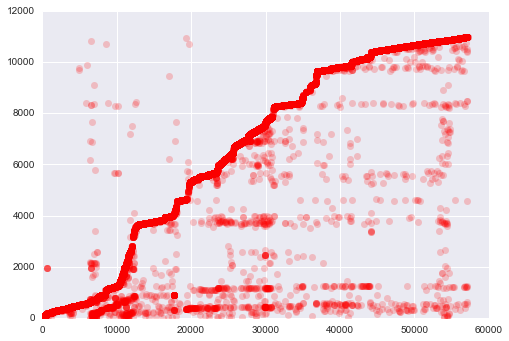

In [21]:
plt.plot(df.page, 'ro', alpha=0.2)

### 3.2. Удаление аномальных номеров страниц
**(аппроксимируем неубывающую функцию, а всё, что далеко от неё - удаляем, повторять итеративно)**

In [22]:
from sklearn.isotonic import IsotonicRegression

In [23]:
ir = IsotonicRegression()

##### Итерация 0

In [24]:
df.page.isnull().sum()

7958

In [25]:
page_not_null = ~df.page.isnull()
ir.fit(df.index[page_not_null], df.page[page_not_null])
prediction = ir.transform(df.index)

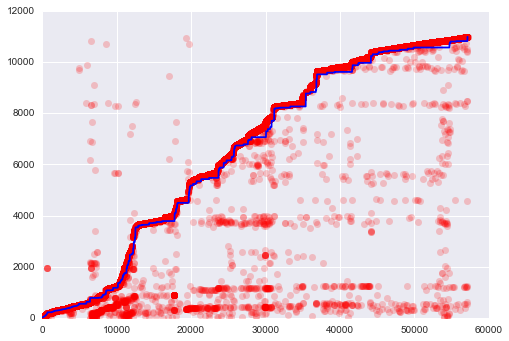

In [26]:
plt.plot(df.page, 'ro', alpha=0.2)
plt.plot(prediction, color='blue')

''

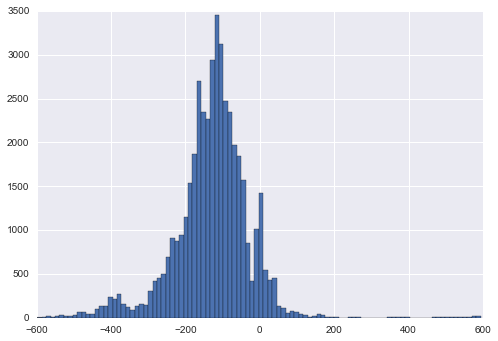

In [27]:
e = prediction - np.array(df.page)
plt.hist(e[(abs(e)>0)&(abs(e)<600)], bins=100)
''

In [28]:
df["page"][abs(e)>450] = None

##### Итерация 1

In [29]:
df.page.isnull().sum()

10007

In [30]:
page_not_null = ~df.page.isnull()
ir.fit(df.index[page_not_null], df.page[page_not_null])
prediction = ir.transform(df.index)

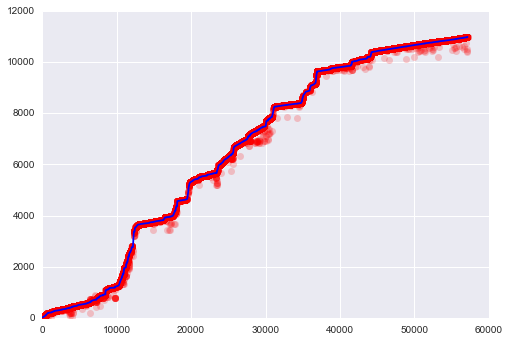

In [31]:
plt.plot(df.page, 'ro', alpha=0.2)
plt.plot(prediction, color='blue')

''

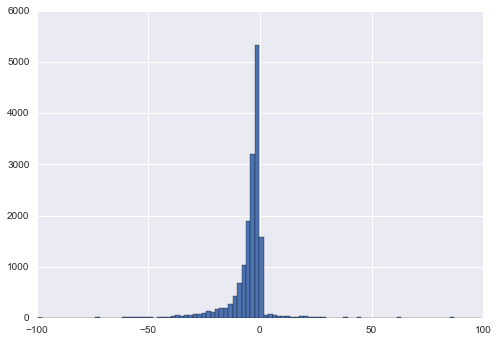

In [32]:
e = prediction - np.array(df.page)
plt.hist(e[(abs(e)>0)&(abs(e)<100)], bins=100)
''

In [33]:
df["page"][abs(e)>50] = None

##### Итерация 2

In [34]:
df.page.isnull().sum()

10463

In [35]:
page_not_null = ~df.page.isnull()
ir.fit(df.index[page_not_null], df.page[page_not_null])
prediction = ir.transform(df.index)

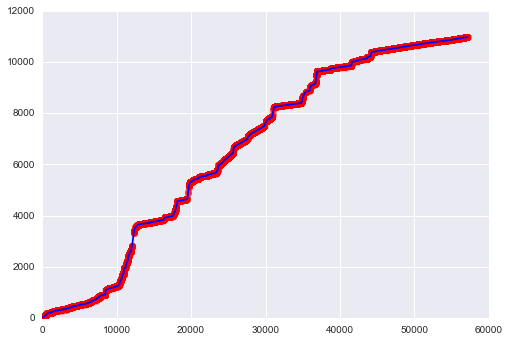

In [36]:
plt.plot(df.page, 'ro', alpha=0.2)
plt.plot(prediction, color='blue')

''

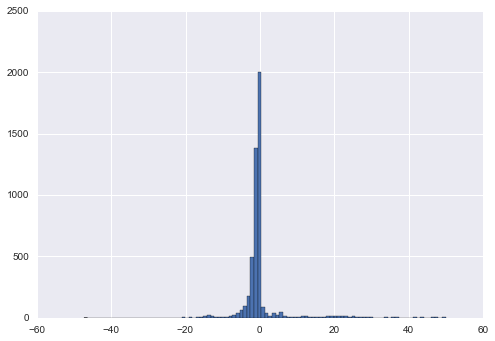

In [37]:
e = prediction - np.array(df.page)
plt.hist(e[(abs(e)>0)&(abs(e)<50)], bins=100)
''

In [38]:
df["page"][abs(e)>25] = None

In [39]:
df.page.isnull().sum()

10542

### 3.3. Заполним однозначно разрешаемые ситуации: между записями на странице N находится запись тоже со страницы N

In [40]:
page_prev = pd.Series([df.page[(i-40):(i+1)].max() for i in range(len(df))])
page_next = pd.Series([df.page[i:(i+40)].min() for i in range(len(df))])

In [41]:
df["page"] = [p if p==v and p and not np.isnan(p) else i for i,p,v in zip(df.page, page_prev, page_next)]

In [42]:
df.page.isnull().sum()

8478

### 3.4. Восполним пробелы подходящими варианты из наборов возможных страниц для каждого ФИО
Идея такая: есть фамилия Иванов в начале страницы 100. Мы по фамилии восстановили страницы [10,40,100,340], взяли минимум 10, выкинули как не подходящий и всё. По окружению тоже не получилось восстановить номер. Так давайте переберём все варианты из списка выше и выберем минимально подходящий? side-effect, каждый раз надо пересчитывать предыдущие при проходе вперёд

In [43]:
new_options = {}

for i in df[df.page.isnull()].index[7:]:
    if pages_options[i]:
        t = [p for p in pages_options[i] if p>=page_prev[i] and p<=page_next[i]]
        if t:
            new_p = min(t)
            new_options.update({i:new_p})
            for i in range(i, i+100):
                if new_p>page_prev[i]:
                    page_prev[i]=new_p
                else:
                    break

In [44]:
len(new_options)

647

In [45]:
df_values = df.values
column_index = np.argmax(df.columns=='page')
for k, v in new_options.items():
    df_values[k][column_index] = v
df = pd.DataFrame(df_values, columns=df.columns)

In [46]:
df.page.isnull().sum()

7831

### 3.5. Повторим шаг 3.3: заполним однозначно разрешаемые ситуции после заполнения новыми данными

In [47]:
df["page"] = [p if p==v and p and not np.isnan(p) else i for i,p,v in zip(df.page, page_prev, page_next)]

In [48]:
df.page.isnull().sum()

7813

### 3.6. Всё что осталось - заменим на аппроксимации

In [49]:
df["page"].loc[[0,1]] = 1
df["page"].loc[[2]] = 5
df["page"].loc[[3,4]] = 6
df["page"].loc[[5,6]] = 8

In [50]:
df["exact_page"] = ~df.page.isnull()

In [51]:
ir.fit(df.index[df.exact_page], df.page[df.exact_page])
prediction = ir.transform(df.index)

In [52]:
def isnan(t):
    try:
        return t is None or np.isnan(t)
    except:
        return False

In [53]:
df["page"] = [page if not isnan(page) else prediction for page, prediction in zip(df.page, prediction)]
df["page"] = df.page.astype(int)

In [54]:
df.page.isnull().sum()

0

In [55]:
df.head(20)

,fio,comment,resolution,part,page,exact_page
0,Захаренко В. А.,Во все разделы правил землепользования и застр...,"Предложения, относящиеся к предмету публичных ...",1,1,True
1,Калантарова Ю. В.,На основании вступившего в законную силу судеб...,"Предложения, относящиеся к предмету публичных ...",1,1,True
2,Ткач Е. В.,"В картах ПЗЗ не отражены ""Защитные зоны ОКН"" (...",Замечание рекомендовано к учёту. Рекомендовать...,1,5,True
3,Крупенина О. Н.,"На карте Градостроительного зонирования ""Грани...",1. Предложение предусмотрено проектом ПЗЗ. На ...,1,6,True
4,Терехов А. С.,Внести в Проект правил землепользования и заст...,Предложение не рекомендовано к учёту. Отсутств...,1,6,True
5,Бегимов М. Н.,Реализация действующего постановления Правител...,Реализация постановления Правительства Москвы ...,1,8,True
6,Кайков И. Бен- Закунимович,Представить правила застройки и землепользован...,"1. В территориальной зоне, в которой расположе...",1,8,True
7,Купцов Л. А.,Учитывая социальную значимость проекта строите...,Предложение не рекомендовано к учёту. Отсутств...,1,9,True
8,Макшанцев М. Н.,Установить зону развития по адресу: Новодевичи...,Предложение не рекомендовано к учёту. Отсутств...,1,9,True
9,Фомина Г. В.,С проектом ПЗЗ ознакомлена,Принято к сведению,1,9,True


## 4. Разделим фамилии
(при списочных историях все ФИО объединялись в одно поле, надо разъединить)

In [56]:
fio_cap = '[А-ЯЁ][а-яё]+'
fio_space = '\s+'
fio_i = '[А-ЯЁа-яёA-Za-z][\.|\,]?'
fio_ii = fio_i+fio_space+fio_i
fio_fio_1part = '[А-ЯЁ][а-яё]+\s?(?:-|–)\s?' # двойная фамилия

fio_patterns = [
    fio_fio_1part+fio_cap+fio_space+fio_cap+fio_space+fio_cap,
    fio_fio_1part+fio_cap+fio_space+fio_cap,
    fio_fio_1part+fio_cap+fio_space+fio_ii,
    fio_fio_1part+fio_cap+fio_space+fio_i,

    fio_cap+fio_space+fio_cap+fio_space+fio_cap,
    fio_cap+fio_space+fio_cap,
    fio_cap+fio_space+fio_ii,
    fio_cap+fio_space+fio_i,

    fio_ii+fio_space+fio_cap,
    
    fio_cap+fio_space+fio_i,
    fio_cap
]
fio_pattern = '|'.join(['('+i+')\\b' for i in fio_patterns])
fio_regex = re.compile(fio_pattern)

In [57]:
fio_splitted_exceptions = ['Соловьиная р', 'Куркинское ш.', 'Новокуркинское ш.', 'Пятницкое ш.',
    'в г. Москва', 'Ангелов п', 'Полесский п', 'Митинский п',
    'Маршала Жукова', 'Героев Панфиловцев', 'Живописная д.', 'Житель р',
    'Бульвар Яна Райниса', 'Строгинский б', 'Карамышевская н',
    'Измайлово п', 'Измайловский п', 'Генерала Глаголева', 'Новокуркинское ш',
    'Генерала Карбышева', 'Маршала Тухачевского', 'т М. Жукова', 'Новикова-Прибоя д.',
    'Генерала Белобородова', 'а, г. Москва', 'Москвы в ч', 'Решение Совета',
    'Новокуркинское щ', 'Волоколамское ш', 'Народного Ополчения', 'Тексты з', 'Пятницкое ш', 'Москва', 'Соловьиная', 'Куркинское ш']

In [58]:
def get_fio_list(q):
    if len(q)<60:
        return [q]
    
    q = q.replace('- ','-').replace(' -','-')
    
    q = re.sub(fio_fio_1part+fio_cap+'\s'+'ул\.', 'ул. #', q)
    q = re.sub('ул\.'+'\s'+fio_fio_1part+fio_cap, 'ул. #', q)
    q = re.sub(fio_cap+'\s'+'ул\.', 'ул. #', q)
    q = re.sub('ул\.'+'\s'+fio_cap, 'ул. #', q)
    
    len_before = len(q)
    
    l = q.split(' ') # неразрывный пробел
    l = sum([i.split('\n') for i in l], [])
    l = sum([[''.join(f) for f in fio_regex.findall(i)] for i in l], [])
    l = [i.replace(' ',' ').strip() for i in l]
    l = [i for i in l if i not in fio_splitted_exceptions]
    
    for i in l:
        q = q.replace(i,'')
    q = q.replace(' ',' ').replace('\n',' ').replace(',','')
    q = re.sub(' +',' ',q)
    len_after = len(q)
    num_adress = max(len(re.findall('ул.', q)), len(re.findall('д.', q)))
    
    if len(l)>10 or len(l)>3 and ((len_after - 15*num_adress < 30) or len_after/len_before<0.2):
        return l
    
    return [q]

In [59]:
cnt = 0
ndf_values = []
df_values = df.values
orig_ids = []
list_flag = []
column_index = np.argmax(df.columns=='fio')
for i, row in enumerate(df_values):
    fios = get_fio_list(row[column_index])
    if len(fios)==1:
        orig_ids.append(i)
        list_flag.append(False)
        ndf_values.append(row)
    else:
        cnt += 1
        for fio in fios:
            orig_ids.append(i)
            list_flag.append(True)
            new_row = row.copy()
            new_row[column_index] = fio
            ndf_values.append(new_row)
ndf = pd.DataFrame(ndf_values, columns=df.columns)
ndf["orig_id"] = orig_ids
ndf["list_flag"] = list_flag
ndf.index = range(len(ndf))

In [60]:
ndf.head()

,fio,comment,resolution,part,page,exact_page,orig_id,list_flag
0,Захаренко В. А.,Во все разделы правил землепользования и застр...,"Предложения, относящиеся к предмету публичных ...",1,1,True,0,False
1,Калантарова Ю. В.,На основании вступившего в законную силу судеб...,"Предложения, относящиеся к предмету публичных ...",1,1,True,1,False
2,Ткач Е. В.,"В картах ПЗЗ не отражены ""Защитные зоны ОКН"" (...",Замечание рекомендовано к учёту. Рекомендовать...,1,5,True,2,False
3,Крупенина О. Н.,"На карте Градостроительного зонирования ""Грани...",1. Предложение предусмотрено проектом ПЗЗ. На ...,1,6,True,3,False
4,Терехов А. С.,Внести в Проект правил землепользования и заст...,Предложение не рекомендовано к учёту. Отсутств...,1,6,True,4,False


In [61]:
ndf.shape

(114011, 8)

In [62]:
ndf.to_excel('data_progress/2 PZZ.xlsx')

------

------

# Архив: Скрипт для интерполяции неизвестных страниц

# Архив: Для поиска ошибок